In [1]:
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

#All the scripts we are going to use are defined in different .py files, in order to make them easier to manage. 
from loadconfiguration import LoadConfiguration
from logconversion import LogConversion
from getspectrafile import GetSpectraFile 
from calcworkpoint import CalcWorkPoint
from findmixcal import FindMixCal
from caliq import Cal_IQ
from shift2pos import Shift2Pos
from backgroundcalibration import BackgroundCalibration
from correctiq import CorrectIQ
from findiqcorrection import Background
from correctiqbackground import CorrectIQBackground
from readdata import ReadData
from displog import DispLog

#All our globally defined variables are stored in "globalvar.py". This ensures the code does not encounter cyclic definition of variables
import globvar

#def ConvertIQ2Af4(run_num, meas_num, spectra_path, iqpath, save_path, iqheader, mode, nch,  datatype):

#Default settings block. Useful in order to debug the code, these should be the argument for the ConvertIQ2Af4 function.

#spectra_path is the path to the Spectra Folder, which contains many file, among which there also is the spectra file
spectra_path = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Data\\Spectra'
run_num = 34
datatype = 'MixCh'
meas_num = 1
save_path = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Save'
iqpath = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\IQ\\run' + str(run_num) + '\\'
iqheader = ['IQ0Ch1', 'IQ0Ch2']
nch = 2
mode = 0
ifplot = 0

config = LoadConfiguration(spectra_path + "\\run" + str(run_num) + '\\' + datatype + str(meas_num) + '.log')

#We modify recordlength and adcconv globally...
globvar.recordlength = int(config[2][1])
npoints = globvar.recordlength
globvar.adcconv = float(config[0][1])
samprate = float(config[1][1])
attenuations = [float(config[14][1]) + float(config[15][1])]
dataformat = globvar.dataformat
globvar.nchan = nch

#...then we store them in a local variable.
recordlength = int(globvar.recordlength)
adcconv = globvar.adcconv

#Show how data have been arranged
print('Formato dati: ' + str(globvar.dataformat))
print('Lunghezza record: ' + str(globvar.recordlength))

#We want to create the check directory and the log file. We modify checkpath and logpath globally...
globvar.checkpath = save_path + '\\check_meas' + datatype + str(meas_num)
globvar.logpath = save_path + '\\run' + str(run_num) + '\\' + datatype + str(meas_num) +'.log'

#...then we store them in a local variable. Their content should not be modified later, and the other script
#we will call can retain the value we assigned in the earlier rows by importing the value, now updated as to lines 48 and 49.
logpath = globvar.logpath
checkpath = globvar.checkpath

#Create directories in which store correction results and logs
os.mkdir(save_path)
os.mkdir(save_path + '\\run' + str(run_num))
log = open(logpath, 'a')
log.close()
os.mkdir(checkpath)

#For each IQ datatype data we declare a proper string. This is done in order to retrieve the IQ Data, not the Spectra Data! 
#For an example, see the folder for run34: we have the same kind of data for both MixCh0 and MixCh1. 
iqfileheader_ch = []
for ii in range(nch):
    iqfileheader_ch.append(iqpath + str(iqheader[ii]) + '_')

spectra_path_run = spectra_path + '\\run' + str(run_num)
print('Spectra Files root: ' + spectra_path_run)
file_name = GetSpectraFile(spectra_path_run)

if isinstance(file_name, str) == False:
    DispLog('Error: more than one file found in spectra path, i don\'t know what to do!')
elif not file_name:
    DispLog('No spectra files found in path: ' + str(spectra_path_run))
    #return 
else:
    DispLog('Path to the spectra file is: ' + str(file_name))

#We now want to compute the WorkPoint frequency
posch = np.zeros(nch)
fmeas = np.zeros(nch)
fmeas2 = np.zeros(nch)
cal_mix_file = ([[]]*nch)

for ii in range (nch):
    [posch[ii], fmeas[ii]] = CalcWorkPoint(spectra_path_run + '\\' + file_name, recordlength, 2*nch, 2*ii, 2*ii+1, iqfileheader_ch[ii], ifplot)
    fmeas2[ii] = float(config[10 + ii][1])
    print('Frequency difference for the ' + str(ii) + '-th channel: ' + str(fmeas[ii]-fmeas2[ii]))

    #Find mixer calibration file closest to the frequency working point
    cal_mix_file[ii] = FindMixCal(fmeas[ii], spectra_path + '\\run' + str(run_num), ii + 1)
    print('Signal frequency for the ' + str(ii + 1) + '-th channel probe: ' + str(fmeas[ii]))
    print('Calibration file for the ' + str(ii + 1) + '-th channel mixer: ' + str(cal_mix_file[ii]))

    #Now ALL input are defined. It's possible to create the log file. The function "logconversion" recalls the 
    #matlab script "logconversion2.m" +  probably an updated version of the original "logconversion.m".
    #Refer to "logconversion2.m" for comparision
LogConversion(fmeas, run_num, meas_num, spectra_path, iqpath, iqheader, cal_mix_file, mode, nch, recordlength)

mixercalfile_ch = []
mixer = []
background = []
qvalues = np.zeros([4, 2])

fmax = np.zeros(nch)
fmin = np.zeros(nch)
amax = np.zeros(nch)
amin = np.zeros(nch)

bufamp = []
buffreq = []
bufpulse = []

f = np.zeros([npoints, nch])
s21xch = np.zeros([npoints, nch])
s21ych = np.zeros([npoints, nch])

for ii in range(nch):
    #Create the string path for mixercalibration. The "ii-th" entry of the
    #object "mixercalfile_ch" is the path to the calibration file for the
    #"ii-th" channel
    mixercalfile_ch.append(spectra_path + '\\run' + str(run_num) + '\\' + cal_mix_file[ii])

    #--------- Begin the IQ loop calibration --------#

    #First we characterize the loop, i.e. we find the parameters that best describe our non - ideal IQ mixer
    mixer.append(Cal_IQ(mixercalfile_ch[ii], 2*nch, 2*ii, 2*ii+1, cal_mix_file[ii], nch, ifplot))
    
    #Fit the mixer calibration data file and find the coefficients used for the correction

    #Fit the background and return the fixed IQ loop

    [back, xchs, ychs, tempf, qvalues[0, ii], qvalues[1, ii], qvalues[2, ii], qvalues[3, ii]] = BackgroundCalibration(iqfileheader_ch[0], mixer[0], fmeas[0], ifplot) #TO MODIFY!!!!
    #[background[ii], s21xch[ii], s21ych[ii], f[ii], qvalues[ii]] = BackgroundCalibration(iqfileheader_ch[ii], mixer[ii], fmeas[ii], ifplot)
    #qvalues stores values in a way such that the row is the channel and the column is one of the four qvalues entries for that channel

    if (s21xch.shape[0] > len(xchs)):  #In order to fix incongruencies with the test - data files...
        diff = int(npoints - len(xchs))
        s21xch = np.delete(s21xch, [len(xchs) + i for i in range(diff)], 0)
        s21ych = np.delete(s21ych, [len(xchs) + i for i in range(diff)], 0)
        f = np.delete(f, [len(xchs) + i for i in range(diff)], 0)

    background.append(back)    
    s21xch[:, ii] = xchs
    s21ych[:, ii] = ychs
    f[:, ii] = tempf

    #Read and convert the pulse data files
    fmax[ii] = -1000000
    fmin[ii] = 1000000
    amax[ii] = -1000000
    amin[ii] = 1000000

original = sys.stdout
log = open(logpath, 'a')
sys.stdout = log
print('\nWritten Files\n')
sys.stdout = original
log.close()


a = np.zeros(nch)
idata = np.zeros([npoints, nch*len(file_names)])
qdata = np.zeros([npoints, nch*len(file_names)])
pulse_data = np.zeros([npoints, nch*len(file_names)])
mapped_pulse_data = np.zeros([npoints, nch*len(file_names)])
amplitude_signal = np.zeros([npoints, nch*len(file_names)])
frequency_signal = np.zeros([npoints, nch*len(file_names)])
buff = np.zeros([npoints, 2*nch*len(file_names)])
t = np.zeros(nch)

#---------------------------------------------------------------------------------------

filefid = spectra_path + '\\run' + str(run_num) + '\\' + file_names[00]
fid = open(filefid)

#generate the write file name and open
writefilename = save_path + str(file_names[jj][0:-5]) + '_proc.txt'

log = open(logpath, 'a')
#print(str(file_names[ii] + str(writefilename)))
sys.stdout = original
#print(str(file_names[ii] + str(writefilename)))
log.close()

hh = 0
#while True:
    #line = fid.readline()

data = np.loadtxt(filefid, dtype = dataformat, delimiter = '\t')

if (idata.shape[0] != data.shape[0]):  #In order to fix incongruencies with the test - data files...
    diff = int(npoints - data.shape[0])
    idata = np.delete(idata, [data.shape[0] + i for i in range(diff)], 0)
    qdata = np.delete(qdata, [data.shape[0] + i for i in range(diff)], 0)
    pulse_data = np.delete(pulse_data, [data.shape[0] + i for i in range(diff)], 0)
    mapped_pulse_data = np.delete(mapped_pulse_data, [data.shape[0] + i for i in range(diff)], 0)
    amplitude_signal = np.delete(amplitude_signal, [data.shape[0] + i for i in range(diff)], 0)
    frequency_signal = np.delete(frequency_signal, [data.shape[0] + i for i in range(diff)], 0)
    buff = np.delete(buff, [data.shape[0] + i for i in range(diff)], 0)

if str(data):
    #correct for the mixer - first remove the DC offsets.  We could either use
    #the offset IQ scan or use the offsets found from the IQ calibration data
    #5/2^15 is the ADC to volts scaling

    for ii in range(nch):
        idata[:, nch*jj + ii] = data[:, 2*ii]
        qdata[:, nch*jj + ii] = data[:, 2*ii + 1]
        #Idata{ii} = 5*Idata{ii}(:)/2^15;
        #Qdata{ii} = 5*Qdata{ii}(:)/2^15;

        if dataformat == 'int32':
            idata[:, nch*jj + ii] = adcconv*idata[:, nch*jj + ii]/(2**15)
            qdata[:, nch*jj + ii] = adcconv*qdata[:, nch*jj + ii]/(2**15)
        
        #Apply a correction if it's needed (i.e. mode ~= 0)
        #if mode != 0:
        #    [idata[:][ii], qdata[:][ii], t[:, ii]] = Shift2Pos(idata[:][ii], qdata[:][ii], iqfileheader_ch[ii], ii, hh, ii, posch[ii], ifplot)
        #    a[:, ii] = np.append(a[ii], np.sqrt(t[0, :]**2 + t[1, :]**2))   #i think this should be fixed, don't think "a" is properly declared...

        idata[:, nch*jj + ii] = idata[:, nch*jj + ii] - background[ii].I0
        qdata[:, nch*jj + ii] = qdata[:, nch*jj + ii] - background[ii].Q0

        #print('idata for ch ' + str(ii) +' is ' + str(idata[:, ii]))
        #print('qdata for ch ' + str(ii) +' is ' + str(qdata[:, ii]))

        #Now correct for the mixer gains and phase errors
        [idata[:, nch*jj + ii], qdata[:, nch*jj + ii]] = CorrectIQ(idata[:, nch*jj + ii], qdata[:, nch*jj + ii], mixer[ii])

        #Then apply the background correction
        pulse_data[:, nch*jj + ii] = CorrectIQBackground(fmeas[ii]*np.ones(len(idata[:, nch*jj + ii])), idata[:, nch*jj + ii] + 1j*qdata[:, nch*jj + ii], background[ii])

        #Next apply the rotations, as applied to the IQ loop
        pulse_data[:, nch*jj + ii] = 1 - np.cos(background[ii].LoopRotation)*np.exp(-1j*background[ii].LoopRotation)*(1 - (pulse_data[:, nch*jj + ii]*np.exp(-1j * background[ii].OverallRotation)))
        
        #print(pulse_data)
        
        #now we can convert the timestream data into frequency and dissipation signals
        #through the transformation S_21_mapped = 1 / 1 - S21
        mapped_pulse_data[:, nch*jj + ii] = 1/(1 - pulse_data[:, nch*jj + ii])
        amplitude_signal[:, nch*jj + ii] = np.real(mapped_pulse_data[:, nch*jj + ii])         
        frequency_signal[:, nch*jj + ii] = np.imag(mapped_pulse_data[:, nch*jj + ii])

        buff[:, 2*nch*jj + 2*ii] = amplitude_signal[:, nch*jj + ii]
        buff[:, 2*nch*jj + 2*ii + 1] = frequency_signal[:, nch*jj + ii]

        if (ifplot == 1):
            fig = plt.figure()
            ax1 = fig.add_subplot(4, 1, 1)
            ax1.plot(np.real(pulse_data[:, nch*jj + ii]), np.imag(pulse_data[:, nch*jj + ii]), 'r')
            ax1.plot(s21xch[:, ii], s21ych[:, ii])
            ax1.set_title('ConvertIQ2af4() -> Subplot 1' + str(nch))

            ax2 = fig.add_subplot(4, 1, 2)
            ax2.plot(np.real(pulse_data[:, nch*jj + ii]), np.imag(pulse_data[:, nch*jj + ii]), 'r')
            ax2.plot(s21xch[:, ii], s21ych[:, ii])
            ax2.set_title('ConvertIQ2af4() -> Subplot 2')

            ax3 = fig.add_subplot(4, 1, 3)
            ax3.plot(amplitude_signal[:, nch*jj + ii])
            ax3.set_title('ConvertIQ2af4() -> Subplot 3')

            ax4 = fig.add_subplot(4, 1, 4)
            ax4.plot(frequency_signal[:, nch*jj + ii])
            ax4.set_title('ConvertIQ2af4() -> Subplot 4')

            plt.tight_layout()
            plt.show()

        
    #Look for max and min of the pulse
    for ii in range(nch):            
        loc = max(frequency_signal[:, nch*jj + ii])
        if (loc > fmax[ii]):
            fmax[ii] = loc                
        
        loc = max(amplitude_signal[:, nch*jj + ii])
        if (loc > amax[ii]):
            amax[ii] = loc
    
        loc = min(amplitude_signal[:, nch*jj + ii])
        if (loc < amin[ii]):
            amin[ii] = loc
        
        loc = min(frequency_signal[:, nch*jj + ii])
        if (loc < fmin[ii]):
            fmin[ii] = loc
    
    #Signal to print
    #if (hh < 5 and ii < 3):
        bufamp = amplitude_signal
        buffreq = frequency_signal
        bufpulse = pulse_data  

    np.savetxt(writefilename, buff)

fid.close()

log = open(logpath, 'a')
original = sys.stdout
sys.stdout = log
print('\n---------------- DATA ----------------\n')

for ii in range(nch):
    print('\n\nRESONANCE CH' + str(ii) + ' DATA')
    print('\nQUALITY FACTORS AND FREQUENCY\n')
    print(' \nQ_TOT = ' + str(qvalues[0][ii]) + '\nf0 = ' + str(qvalues[1][ii]) + '\nQi = ' + str(qvalues[2][ii]) + '\nQc = ' + str(qvalues[3][ii]) + '\n')

    print('OTHER DATA\n')
    print('\nCH ' + str(ii) + ' Working point frequency ' + str(fmeas[ii]))
    print('\nCH ' + str(ii) + 'Frequency range ' + str(fmin[ii]) + ' <-> ' + str(fmax[ii]))
    print('\nCH ' + str(ii) + 'Amplitude range ' + str(amin[ii]) + ' <-> ' + str(amax[ii]))
    print('\nCH ' + str(ii) + 'Correction ' + str(np.mean(a[ii])) + ' + / - ' + str(np.std(a[ii])))

print('\nShiftMins = ' + str(amin[0]) + ', ' + str(fmin[0]) + ', ' + str(amin[1]) + ', ' + str(fmin[1]))
print('\nShiftMaxs = ' + str(amax[0]) + ', ' + str(fmax[0]) + ', ' + str(amax[1]) + ', ' + str(fmax[1]))
log.close()
sys.stdout = original

numfiles = len(file_names)
#save([save_path,'/run',num2str(run_num),datatype,num2str(meas_num),'.mat'],'Qvalues','fmeas','run_num','meas_num','spectra_path','IQ_path','IQheader','cal_mix_file','mode','Nch','Recordlength','numfiles','ADCconv','SampRate','Attenuations')
#don't really know how to implement this one...
exts = ['.pdf' '.png']
cmds = ['-dpdf' '-dpng']

#following: you must fix incongruencies with for cicles on jj or nch...
if ifplot == 1 or ifplot == 0:
    for jj in range(len(file_names) - 1):
        for ii in range(nch):
            for i in range(len(exts)):
            
                k1 = plt.figure()
                plt.plot(f[:, ii], (s21xch[:, ii]**2 + s21ych[:, ii]**2)**0.5)
                plt.legend('Re[S21] || CH ' + str(ii))
                plt.xlabel('Frequency')
                plt.ylabel('Quadrature')
                plt.savefig(checkpath + '\\ResonanceCh' + str(ii) + exts[i])

                kt = plt.figure()
                plt.plot(f[:, ii], np.arctan(s21ych[:, ii] / s21xch[:, ii]))
                plt.legend('Im[S21] || CH ' + str(ii))
                plt.xlabel('Frequency')
                plt.ylabel('Phase')
                plt.savefig(checkpath + '\\ResonanceCh' + str(ii) + exts[i]) 
            
                kk = plt.figure()
                plt.plot(np.real(bufpulse[:, ii]), np.imag(bufpulse[:, ii]), 'g')
                plt.plot(s21xch[:, ii], s21ych[:, ii], 'r')
                plt.plot(s21xch[0, ii], s21ych[0, ii], 'o')
                plt.legend(['Ch1 data', 'S21 corr', 'Low freq'])
                plt.xlabel('I, Normalized units')
                plt.ylabel('Q, Normalized units')
                plt.savefig(checkpath + '\\CircleCh' + str(ii) + exts[i])
                
            '''
            if 0:   #this is a way to comment out a part of the code, because what sits inside the 'if 0' condition will never be executed!
                a = plt.figure()
                plot( (1:length(amplitude_signal1)), amplitude_signal1);
                title('Amplitude ch1')
                grid
                legend('Amplitude');
                xlabel('Number of points');
                ylabel('Amplitude');
                print(a,cmds{i},[checkpath,'/PulseAmpch1',exts{i}]);
                
                
                b=figure;
                plot( (1:length(frequency_signal1)), frequency_signal1);
                title( 'Frequency ch1');
                grid
                legend('Amplitude');
                xlabel('Number of points');
                ylabel('Amplitude');
                print(b,cmds{i},[checkpath,'/PulseFreqch1',exts{i}]);
                    
                ll=figure;
                plot( (1:length(amplitude_signal1)), amplitude_signal1,'r');
                title( 'Data Af Ch1')
                
                xlabel('Number of points');
                ylabel('Amplitude');
                
                
                hold on
                
                
                plot( (1:length(frequency_signal1)), frequency_signal1)
                
                grid
                legend('Amplitude','Frequency Amplitude');
                xlabel('Number of points');
                ylabel('Amplitude');
                print(ll,cmds{i},[checkpath,'/PulseFreqch1',exts{i}]);    
            
            
            ler = plt.figure()
            ax = plt.gca()

            H1, = ax.plot(range(1, len(buffamp[ii])+1), bufamp[ii])
            ax.set_xlabel('Sample Index')
            ax.set_ylabel('Amplitude')
            ax.tick_params(axis='y', labelcolor=H1.get_color())

            ax2 = ax.twinx()
            H2, = ax2.plot(range(1, len(bufFreq[ii])+1), bufFreq[ii], 'r')
            ax2.set_ylabel('Frequency')
            ax2.tick_params(axis='y', labelcolor=H2.get_color())

            plt.legend([H1, H2], ['Amplitude', 'Frequency'])
            plt.title('Amplitude and Frequency')
            '''
    
log = open(logpath, 'a')
original = sys.stdout
sys.stdout = log
print('---------------End Conversion---------------------------------------------')
sys.stdout = original
#return


Formato dati: int16
Lunghezza record: 4000
Spectra Files root: \Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\Data\Spectra\run34
Frequency difference for the 0-th channel: 277423.0


ValueError: could not convert string to float: ''

Keep the following cell as a guide to handle matrices in python!

In [6]:
vec = np.zeros([4, 6])
vector = np.zeros([4, 2])
vector[:, 0] = np.array([1, 3, 4, 5])
vec[:, 0:2] = vector
print(vec)

[[1. 0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0.]]


In [5]:
from readdata import ReadData
[idata, qdata] = ReadData('C:\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Data\\Spectra\\run34\\run34_spectra0.txt', 0, 1)

- DispLog(): ERROR: Log file not found 
- ReadData(): OK: The two data arrays have the same length for file: C:\Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\Data\Spectra\run34\run34_spectra0.txt


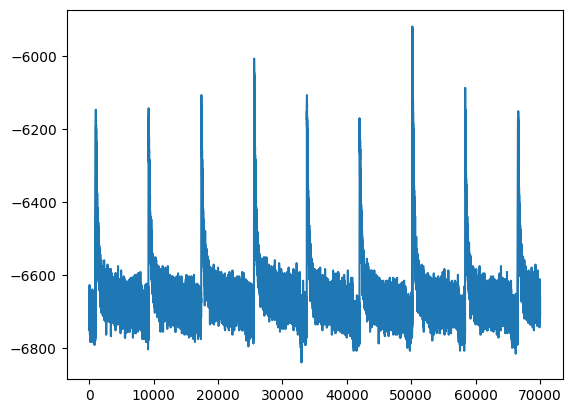

In [7]:
from matplotlib import pyplot as plt
import numpy as np
freq = np.linspace(0, len(idata), len(idata))
plt.plot(freq[0:70000], idata[0:70000])

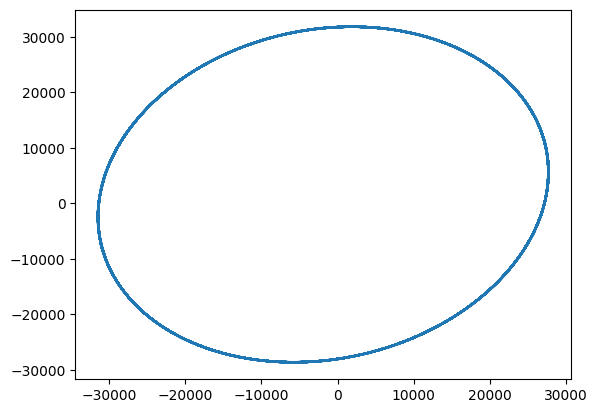

: 

In [9]:
filename = 'C:\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Data\\Spectra\\run34\\MixCh1_5785937577.txt'
data = np.loadtxt(filename, dtype = float, delimiter = '\t')
plt.plot(data[:, 0], data[:, 1])


In [28]:
import numpy as np
from mathfunctions import MaxColumnWise

vec = [1, 3, 4, 5, 8, 2, 3, 2, 8]
vec = np.array(vec)
print(vec)
np.argmax(vec)

[1 3 4 5 8 2 3 2 8]


4

In [34]:
vec = [1, 2, 4]
print(vec)
vec[- 2]

[1, 2, 4]


2